# VALORACIÓN DE OPCIONES USANDO ÁRBOLES

### Parámetros necesarios para valorar una opción:

| Descripción | Símbolo|
| -------------------------------------------------- | ---------|
| Valor actual del activo | **S0** |
| Valor de strike de la opción | **K** |
| Tasa de interés anual del activo libre de riesgo | **r** |
| Dividendos del activo | **div** |
| Tiempo hasta vencimiento | **T** |
| Varianza del activo | **sigma** |
| Número de intervalos hasta vencimiento | **n** |


Incremento del valor del activo: <font size="5"> $$u = e^{(\sigma * \sqrt{\Delta t})}$$</font>

Descenso del valor del activo: <font size="5">$$d = 1/u $$</font>

Intervalo <font size="5"> $$ \Delta t = \frac{T}{n} $$ </font>

Probabilidad de que el activo suba: <font size="5"> $$ p = \frac{e^{(-r*\Delta t - div)}}{(u-d)}$$ </font>

<center>
<img src="imgs/arbol binomial.png"  alt="drawing" width="30%"/>
</center>

In [8]:
import numpy as np
import pandas as pd
import math as m
import scipy.stats as stats
import mibian
import seaborn as sns
# import plotly.graph_objects as go

# pd.options.plotting.backend = "plotly"

import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [9]:
def treeparams(T, r, div, n, sigma):
    
    dt = float(T/n)
    u = np.exp(sigma*(np.sqrt(dt)))
    d = 1/u
    pu = (np.exp((r-div)*dt) - d) / (u - d)
    pd = 1 - pu
    tree_dict = {"dt": dt, "u": u, "d": d, "pu": pu, "pd": pd}

    return tree_dict

In [10]:
def stockpricetree(S0, u, d, n):
    tmp_stocktree = np.zeros((n+1,n+1))
    for j in range(n+1):
        for i in range(j+1):
            tmp_stocktree[i][j] = S0*(u**i)*(d**(j-i))
    return tmp_stocktree

In [11]:
def probabilitytree(pu, pd, n):
    tmp_probTree = np.zeros((n+1,n+1))
    for j in range(n+1):
        for i in range(j+1):
            tmp_probTree[i][j] = m.factorial(j) / (m.factorial(i) * m.factorial(j-i))\
                                                        * pu**i * pd**(j-i)
    return tmp_probTree

In [12]:
def europeanpayofftree(pricetree, K, type = "Call"):
    #Initialize all payoff nodes to zeros
    n = pricetree.shape[0] - 1
    tmp_payofftree = np.zeros((n+1,n+1))
    
    iopt = 0
    #Get payoffs at terminal nodes at the option maturity
    if type == "Call":
        iopt = 1
    else:
        iopt = -1

    # Get payoffs at terminal nodes
    for i in range(n+1):
        tmp_payofftree[i][n] = np.maximum(0, iopt * (pricetree[i][n]-K))

    return tmp_payofftree
            

In [13]:
def backwardsdiscount(payofftree, probtree, r, T):

    n = payofftree.shape[0] - 1
    terminalpayoff = 0.0
    for i in range(n+1):
        terminalpayoff = terminalpayoff + payofftree[i][n] * probtree[i][n]
    optionprice = terminalpayoff * np.exp(-r * T)

    return optionprice

In [14]:
def calcoptionprice(S0, K, T, r, div, n, sigma, type="Call"):
    tree_dict = treeparams(T, r, div, n, sigma)
    price_tree = stockpricetree(S0, tree_dict["u"], tree_dict["d"], n)
    prob_tree = probabilitytree(tree_dict["pu"], tree_dict["pd"], n)
    payoff_tree = europeanpayofftree(price_tree, K, type = "Call")
    price_opt = backwardsdiscount(payoff_tree, prob_tree, r, T)
    return price_opt

In [15]:
csco_opt_calls = pd.read_excel('./data/csco_opt.xlsx')

array([<AxesSubplot:xlabel='strike'>, <AxesSubplot:xlabel='strike'>],
      dtype=object)

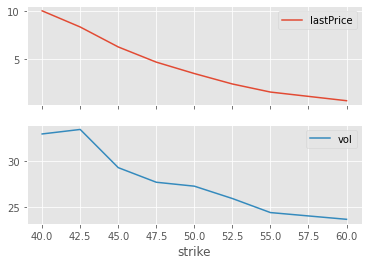

In [16]:
csco_opt_calls[['strike' , 'lastPrice', 'vol']].plot(x='strike', subplots=True)

In [17]:
pos = 0
S0 = csco_opt_calls.loc[pos, "S0"]
K = csco_opt_calls.loc[pos, "strike"]
T = csco_opt_calls.loc[pos, "T"]
r = 0.01
div = 0.0 #0.03
sigma = csco_opt_calls.loc[pos, "vol"]/100
steps = 10

In [18]:

tree_param_dict = treeparams(T, r, div, steps, sigma)

In [19]:
tree_param_dict

{'dt': 0.057534246575342465,
 'u': 1.082265360455063,
 'd': 0.9239878097729446,
 'pu': 0.48388225559446985,
 'pd': 0.5161177444055302}

In [20]:
opt_price_tree = stockpricetree(S0, tree_param_dict["u"], tree_param_dict["d"], steps)

In [21]:
opt_prob_tree = probabilitytree(tree_param_dict["pu"], tree_param_dict["pd"], steps)

In [22]:
opt_payoff_tree = europeanpayofftree(opt_price_tree, K)

In [23]:
backwardsdiscount(opt_payoff_tree, opt_prob_tree, r, T)

10.235069969938007

In [24]:
calcoptionprice(S0, K, T, r, div, steps, sigma)

10.235069969938007

In [25]:
price_calc=[]
S0 = csco_opt_calls.loc[0, "S0"]
T = csco_opt_calls.loc[0, "T"]
r = 0.01
div = 0.0 #0.03
steps = 50

for i in range(csco_opt_calls.shape[0]):
      
    K = csco_opt_calls.loc[i, "strike"]
    sigma = csco_opt_calls.loc[i, "vol"]/100
    price_calc.append(calcoptionprice(S0, K, T, r, div, steps, sigma))

csco_opt_calls["price_calc"] = price_calc

In [26]:
price_calc=[0]
S0 = csco_opt_calls.loc[0, "S0"]
T = csco_opt_calls.loc[0, "T"]
r = 0.01
div = 0.0 #0.03
steps = 50

for i in range(csco_opt_calls.shape[0]-1):
      
    K = csco_opt_calls.loc[i+1, "strike"]
    sigma = csco_opt_calls.loc[i, "vol"]/100
    price_calc.append(calcoptionprice(S0, K, T, r, div, steps, sigma))

csco_opt_calls["price_calc_1"] = price_calc

In [27]:
csco_opt_calls

,lastTradeDate,strike,lastPrice,S0,T,vol,price_calc,price_calc_1
0,2022-08-19,40.0,10.05,48.700001,0.575342,32.958984,10.225801,0.000000
1,2022-08-19,42.5,8.35,48.700001,0.575342,33.447266,8.501127,8.440819
2,2022-08-19,45.0,6.25,48.700001,0.575342,29.296875,6.417078,6.947240
3,2022-08-19,47.5,4.65,48.700001,0.575342,27.709961,4.811855,5.038865
4,2022-08-19,50.0,3.45,48.700001,0.575342,27.282715,3.588053,3.651195
5,2022-08-19,52.5,2.35,48.700001,0.575342,25.939941,2.460396,2.649511
6,2022-08-19,55.0,1.50,48.700001,0.575342,24.414062,1.550209,1.739295
7,2022-08-19,60.0,0.59,48.700001,0.575342,23.681641,0.616790,0.674479


In [28]:
sigma = csco_opt_calls.loc[0, "vol"]/100
S0 = csco_opt_calls.loc[0, "S0"]
T = csco_opt_calls.loc[0, "T"]
r = 0.01
div = 0.0 #0.03
steps = 9

price_calc=[0]

for i in range(csco_opt_calls.shape[0]-1):
   
    K = csco_opt_calls.loc[i+1, "strike"]
    price_calc.append(calcoptionprice(S0, K, T, r, div, steps, sigma))

csco_opt_calls["price_calc_0"] = price_calc

<AxesSubplot:xlabel='strike'>

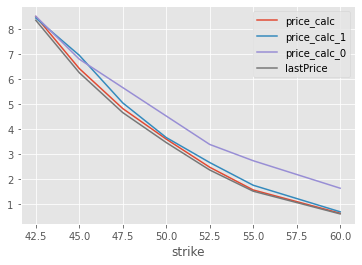

In [29]:
csco_opt_calls.iloc[1:, :].plot(kind='line', x='strike', y=['price_calc', 'price_calc_1','price_calc_0','lastPrice'])